In [176]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
from regression_dsets_large_names import regression_dsets_large_names
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import fit
from process_results import process_results, aggregate_results, best_ridge
import statsmodels.tsa.api as smt
from statsmodels.tsa.tsatools import lagmat
import numpy.linalg as npl

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# look at eigenvals

In [177]:
def complexity(n, d, cov, thetastar, sigma=1):
    (u, a, h) = npl.svd(cov)
#     plt.plot(a, 'o-')
#     plt.ylabel('s.v.')
    w = u.T @ thetastar
    comps = []
    results = {}
    ls = np.hstack((np.linspace(0, 1, 300), np.linspace(1, 100, 300)))
    for l in ls:
        comp = - min(n, d) / 2 
        for i in range(min(n, d)):
            comp += l**2 / 2 * (a[i] * w[i]**2 / sigma**2 + 1) / (l + a[i])**2
        for i in range(min(n, d)):
            comp += np.log(1 + a[i] / l)
        comps.append(comp)
    return {
        'ls': ls,
        'comps': comps,
        'complexity': np.min(comps),
        'svs': a
    }
    
# r = complexity(n, d, X.T @ X, thetastar)

In [181]:
ns = [5, 10, 25, 100, 150, 200, 400, 500, 1000, 1200, 1500, 1800, 2000, 3000]
d = 500
complexities = []

thetastar = np.random.randn(d)
thetastar /= npl.norm(thetastar)

for n in tqdm(ns):

    X = np.random.randn(n, d) / np.sqrt(n)
    r = complexity(n, d, X.T @ X, thetastar)
    complexities.append(r['complexity'])

  0%|          | 0/14 [00:00<?, ?it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
100%|██████████| 14/14 [00:14<00:00,  1.54s/it]


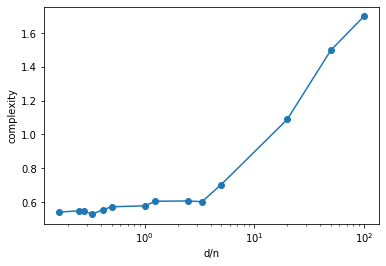

In [182]:
plt.plot([d/x for x in ns], complexities, 'o-')
plt.xscale('log')
plt.xlabel('d/n')
plt.ylabel('complexity')
plt.show()

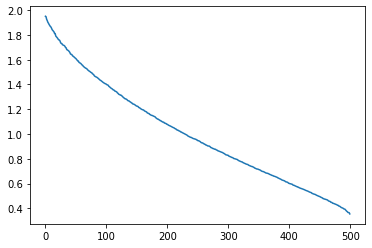

In [183]:
plt.plot(r['svs'])

# ar models

-0.5384131204383905


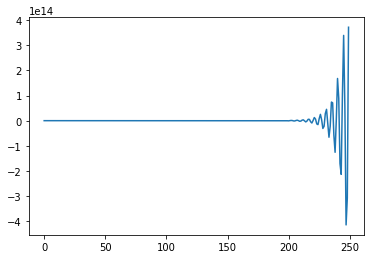

In [161]:
# np.random.seed(12345)
d = 8
thetastar = np.random.uniform(low=-0.5, high=0.5, size=d+1)
thetastar[0] = 1
s = np.sum(thetastar[1:])
print(s)
thetastar[1:] -= s

# arparams = np.array([1, -1.5, 1.5])

n = 250
sample = smt.arma_generate_sample(ar=thetastar, ma=np.array([1]), nsample=n, sigma=1)
plt.plot(sample)

In [172]:
ns = [505, 520, 550, 600, 650, 700, 1000, 1200, 1500, 1800, 2000, 3000]
d = 500
complexities = []

for n in tqdm(ns):
    thetastar = np.random.uniform(low=-0.5, high=0.5, size=d+1)
    thetastar[0] = 1
    s = np.sum(thetastar[1:])
    thetastar[1:] -= s

    sample = smt.arma_generate_sample(ar=thetastar[1:], ma=np.array([1]), nsample=n, sigma=1)
    A = lagmat(sample, maxlag=d, trim='both')
    r = complexity(n, d, A.T @ A, thetastar[1:])
    complexities.append(r['complexity'])

  0%|          | 0/12 [00:00<?, ?it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
 17%|█▋        | 2/12 [00:03<00:15,  1.51s/it]/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
100%|██████████| 12/12 [00:18<00:00,  1.55s/it]


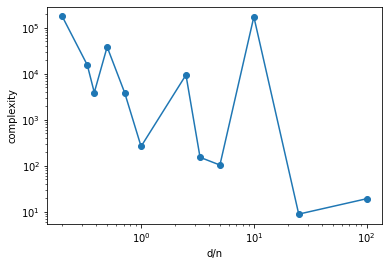

In [175]:
plt.plot([d/(x - d) for x in ns], complexities, 'o-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('d/n')
plt.ylabel('complexity')
plt.show()

# arma

In [34]:
np.random.seed(12345)
# arparams = np.array([1, -0.75, 0.25])
arparams = np.array([1, -0.5, 0.5])
maparams = np.array([1]) #, .65, .35])
# ar = np.r_[1, -arparams] # add zero-lag and negate
# ma = np.r_[1, maparams] # add zero-lag

n = 250
sample = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, sigma=1)
plt.plot(sample)